In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
np.random.seed(1)

In [26]:
# (a) Loading data and computing correlations.
X_train = pd.read_csv('train.csv', header=None)
y_train = X_train.iloc[:,-1:] # The target y is included as the last column of train.csv.
X_train = X_train.iloc[:,:-1]
correlations=[]
for name,data in X_train.items():
    x=round(pearsonr(x=X_train[name],y=y_train).statistic[0],2)
    correlations.append(x)
    print(f"Correlation between {name+1}th predictor and the response variable is equal to: {x}")

Correlation between 1th predictor and the response variable is equal to: -0.35
Correlation between 2th predictor and the response variable is equal to: -0.06
Correlation between 3th predictor and the response variable is equal to: -0.57
Correlation between 4th predictor and the response variable is equal to: -0.24
Correlation between 5th predictor and the response variable is equal to: -0.13


In [27]:
# (b) Fitting the bagging model
p = 100    # Number of trees to be used
y_train = np.ravel(y_train)
bagging = [RandomForestRegressor(n_estimators=1).fit(X_train,y_train) for x in range(p)]                  # Define and fit the model

In [28]:
# (c) Loading the test data...
X_test = pd.read_csv('test.csv', header=None)
y_test =X_test.iloc[:,-1:] # As above, the target is included as the last column of test.csv.
y_test = np.ravel(y_test)
X_test = X_test.iloc[:,:-1]
# ...and computing the correlations between the different trees in the model
def prediction_corr(model, X, y) -> float:
    S = []
    for m in range(len(model)):
        pred_m = model[m].predict(X_test)
        for i in range(m+1, len(model)):
            pred_i = model[i].predict(X_test)
            S.append(pearsonr(pred_m,pred_i))
    return np.mean(S)
print(prediction_corr(model=bagging,X=X_test,y=y_test))

0.3230981233804518


In [29]:
# (d) Computing the correlations between the residuals instead
def residual_corr(model, X, y):
    S = []
    for m in range(len(model)):
        pred_m = model[m].predict(X_test)
        res_m=y_test-pred_m
        for i in range(m+1, len(model)):
            pred_i = model[i].predict(X_test)
            res_i=y_test-pred_i
            S.append(pearsonr(res_m,res_i)) 
    return np.mean(S)
print(residual_corr(bagging,X_test,y_test))

0.29740053523012566


The correlation between the residuals indicates whether the different models learned different things about the data, or if each one of them makes the same mistakes. The correlation between the residuals should be as low as possible. In comparison, the correlation between predictions just tell us, whether the models have comparable predictions for the same data. This makes the correlation between residuals much more informative.

In [30]:
# (e) Training RFs with different numbers of subsampled features for each tree
RFs = dict()
Qs = np.linspace(0.2,1,5) 
for q in Qs:
    RFs[q]=RandomForestRegressor(n_estimators=100,max_features=q).fit(X_train,y_train)

<AxesSubplot: >

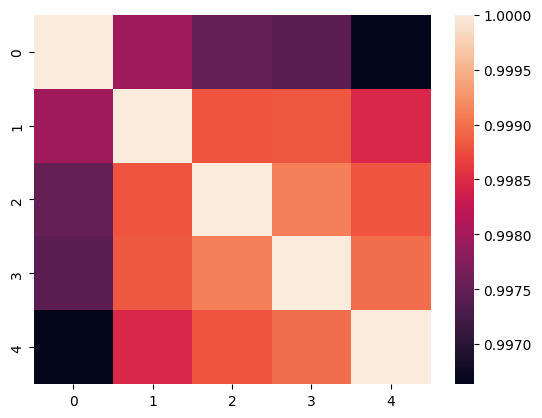

In [31]:
# (f) Residual correlations for different numbers of features
rf_res_corr = []
for q in Qs:
    rf_res_corr.append(y_test-RFs[q].predict(X_train))
df = pd.DataFrame(rf_res_corr)
df=df.transpose()
sns.heatmap(df.corr())

As all the correlations are very close to one, it means that for any subset of features we get very similiar results.

C:\Users\48604\AppData\Local\Temp\ipykernel_31760\4017755363.py:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


Text(0, 0.5, 'Feature importance')

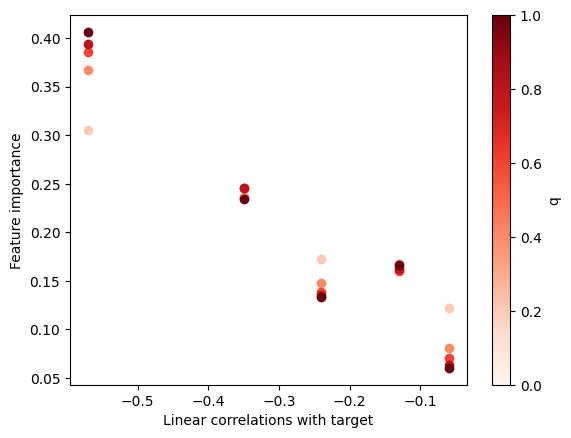

In [32]:
# (g) Computing the feature importances and plotting them against the linear correlations
cmap = cm.Reds
for q in Qs:
    color = cmap(q)
    # Fill this in
    importance=RFs[q].feature_importances_
    plt.scatter(x=correlations,y=importance, color=color)
    
# Stuff to make it look decent
sm = plt.cm.ScalarMappable(cmap=cmap)
cbar = plt.colorbar(sm)
cbar.set_label('q')
plt.xlabel('Linear correlations with target')
plt.ylabel('Feature importance')

As expected, the most restricted model assigned much more importance to the least-correlated feature, because it had not other choice. As a result, the most correlated feature got much less importance than in less restricted model. The non constrained model focused on the most correlated features, which was expected.